In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import gzip
import csv
import time
from torch.nn.utils.rnn import pack_padded_sequence
import math

In [2]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [3]:
class NameDataset(Dataset):
    def __init__(self, is_train_set=True):

        #读数据
        filename = "/Users/shenxinyi/Documents/pytorch/name/names_train.csv.gz" if is_train_set else "/Users/shenxinyi/Documents/pytorch/name/names_test.csv.gz"
        with gzip.open(filename, 'rt') as f:
            reader = csv.reader(f)
            rows = list(reader)

        #数据元组（name,country）,将其中的name和country提取出来，并记录数量
        self.names = [row[0] for row in rows]
        self. len = len(self.names)
        self.countries = [row[1] for row in rows]

        #将country转换成索引
        #列表->集合->排序->列表->字典
        self.country_list = list(sorted(set(self.countries)))
        self.country_dict = self.getCountryDict()
        #获取长度
        self.country_num = len(self.country_list)

    #获取键值对，country(key)-index(value)
    def __getitem__(self, index):
        return self.names[index], self.country_dict[self.countries[index]]

    def __len__(self):
        return self.len

    def getCountryDict(self):
        country_dict = dict()
        for idx,country_name in enumerate(self.country_list, 0):
            country_dict[country_name]=idx
        return country_dict

    #根据索引返回国家名
    def idx2country(self, index):
        return self.country_list[index]

    #返回国家数目
    def getCountriesNum(self):
        return self.country_num



In [4]:
class RNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers =1 , bidirectional = True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = 2 if bidirectional else 1
        #Embedding层输入 （SeqLen，BatchSize）
        #Embedding层输出 （SeqLen，BatchSize，HiddenSize）
        #将原先样本总数为SeqLen，批量数为BatchSize的数据，转换为HiddenSize维的向量
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        #bidirection用于表示神经网络是单向还是双向
        self.gru = torch.nn.GRU(hidden_size, hidden_size, n_layers, bidirectional = bidirectional)
        #线性层需要*direction
        self.fc = torch.nn.Linear(hidden_size * self.n_directions, output_size)

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions, batch_size, self.hidden_size)

        return hidden

    def forward(self, input, seq_lengths):
        #对input进行转置
        input = input.t()
        batch_size = input.size(1)

        #（n_Layer * nDirections, BatchSize, HiddenSize）
        hidden = self._init_hidden(batch_size)
        #(SeqLen, BatchSize, HiddenSize)
        embedding = self.embedding(input)

        #对数据计算过程提速
        #需要得到嵌入层的结果（输入数据）及每条输入数据的长度
        gru_input = pack_padded_sequence(embedding, seq_lengths)

        output, hidden = self.gru(gru_input, hidden)

        #如果是双向神经网络会有h_N^f以及h_1^b两个hidden
        if self.n_directions == 2:
            hidden_cat = torch.cat([hidden[-1], hidden[-2]], dim=1)
        else:
            hidden_cat = hidden[-1]

        fc_output = self.fc(hidden_cat)

        return fc_output

In [5]:
def name2list(name):
    arr = [ord(c) for c in name]
    return arr, len(arr)


def make_tensors(names, countries):
    sequences_and_length = [name2list(name) for name in names]
    #取出所有的列表中每个姓名的ASCII码序列
    name_sequences = [s1[0] for s1 in sequences_and_length]
    #将列表车行度转换为LongTensor
    seq_lengths = torch.LongTensor([s1[1] for s1 in sequences_and_length])
    #将整型变为长整型
    countries = countries.long()

    #做padding
    #新建一个全0张量大小为最大长度-当前长度
    seq_tensor = torch.zeros(len(name_sequences), seq_lengths.max()).long()
    #取出每个序列及其长度idx固定0
    for idx, (seq, seq_len) in enumerate(zip(name_sequences, seq_lengths), 0):
        #将序列转化为LongTensor填充至第idx维的0到当前长度的位置
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    #返回排序后的序列及索引
    seq_lengths, perm_idx = seq_lengths.sort(dim = 0, descending = True)
    seq_tensor = seq_tensor[perm_idx]
    countries = countries[perm_idx]

    return seq_tensor,seq_lengths, countries

In [6]:
def trainModel():
    total_loss = 0
    for i, (names, countries) in enumerate(trainloader, 1):
        inputs, seq_lengths, target = make_tensors(names, countries)
        output = classifier(inputs, seq_lengths)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % 10 == 0:
            print(f'[{time_since(start)}] Epoch {epoch} ', end='')
            print(f'[{i * len(inputs)}/{len(trainset)}]', end='')
            print(f'loss={total_loss / (i * len(inputs))}')

    return total_loss

In [7]:
def testModel():
    correct = 0
    total = len(testset)
    print("evaluating trained model……")
    with torch.no_grad():
        for i, (names, countries) in enumerate(testloader, 1):
            inputs, seq_lengths, target = make_tensors(names, countries)
            output = classifier(inputs, seq_lengths)
            pred = output.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        percent = '%.2f' % (100*correct/total)
        print(f'Test set: Accuracy {correct}/{total} {percent}%')
    return correct/total

Training for 20 epochs ... 
 0s] Epoch 1 [1280/13374]loss=0.017481773998588322
 1s] Epoch 1 [2560/13374]loss=0.015342059964314102
 1s] Epoch 1 [3840/13374]loss=0.0139251205449303
 2s] Epoch 1 [5120/13374]loss=0.013092188304290176
 3s] Epoch 1 [6400/13374]loss=0.012461316399276256
 3s] Epoch 1 [7680/13374]loss=0.011901024434094628
 4s] Epoch 1 [8960/13374]loss=0.011422187156443084
 5s] Epoch 1 [10240/13374]loss=0.011024660372640938
 5s] Epoch 1 [11520/13374]loss=0.010642114038475686
 6s] Epoch 1 [12800/13374]loss=0.010363437430933119
evaluating trained model……
Test set: Accuracy 4791/6700 71.51%
 7s] Epoch 2 [1280/13374]loss=0.006365378340706229
 8s] Epoch 2 [2560/13374]loss=0.006653905613347888
 9s] Epoch 2 [3840/13374]loss=0.006638768749932448
 9s] Epoch 2 [5120/13374]loss=0.006614880776032806
 10s] Epoch 2 [6400/13374]loss=0.0066264242026954885
 11s] Epoch 2 [7680/13374]loss=0.006547232631904384
 11s] Epoch 2 [8960/13374]loss=0.006490245887211391
 12s] Epoch 2 [10240/13374]loss=0.006

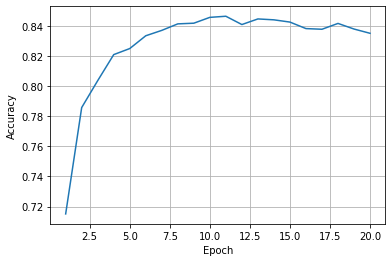

In [9]:
if __name__ == '__main__':
    '''
    N_CHARS：字符数量，英文字母转变为One-Hot向量
    HIDDEN_SIZE：GRU输出的隐层的维度
    N_COUNTRY：分类的类别总数
    N_LAYER：GRU层数
    '''

    HIDDEN_SIZE = 100
    BATCH_SIZE = 128
    N_LAYER = 2
    N_EPOCH = 20
    N_CHAR = 128 #ASCII
    N_COUNTRY = 18
    USE_GPU = False
    
    trainset = NameDataset(is_train_set = True)
    trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    testset = NameDataset(is_train_set=False)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    #最终的输出维度
    N_COUNTRY = trainset.getCountriesNum()
    
    classifier = RNNClassifier(N_CHAR, HIDDEN_SIZE, N_COUNTRY, N_LAYER)
    #迁移至GPU
    if USE_GPU:
        device = torch.device("cuda:0")
        classifier.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    start = time.time()
    print("Training for %d epochs ... " % N_EPOCH)
    #记录训练准确率
    acc_list = []
    for epoch in range(1, N_EPOCH+1):
        #训练模型
        trainModel()
        #检测模型
        acc = testModel()
        acc_list.append(acc)

    #绘制图像
    epoch = np.arange(1, len(acc_list)+1, 1)
    acc_list = np.array(acc_list)
    plt.plot(epoch, acc_list)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()